<a href="https://colab.research.google.com/github/maxMitsuya/analise-lr-rf-xgboost/blob/main/Analise_Compartiva_lr_rf_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Comparativa de Modelos de Previsão com Otimização de Hiperparâmetros

## Objetivo
Este estudo realiza uma avaliação sistemática comparando o desempenho de três algoritmos de machine learning - Regressão Logística, Random Forest e XGBoost - em sua configuração padrão e após otimização de hiperparâmetros utilizando GridSearchCV. O foco principal é entender como o ajuste fino de parâmetros impacta a capacidade preditiva de cada modelo para a tarefa de previsão de churn.

## Contexto
Uma empresa está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn.

Diante deste cenário, vamos implementar três modelos de classificação: Logistic Regression, Random Forest e XGBoost no intuito de comparar seus resultados e realizar processos de otimização de hiperparâmetros.

## Sobre os dados

O conjunto de dados é uma adaptação do dataset sobre informações de uma empresa de e-commerce disponível em: [kaggle](https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download)

## Setup

In [35]:
!pip install --upgrade matplotlib seaborn

In [36]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            precision_score, recall_score, f1_score,
                            roc_auc_score, confusion_matrix)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns

## Carregamento e tratamento dos dados

In [37]:
df = pd.read_excel('E_Commerce_Dataset.xlsx')

In [38]:
df.head()

,CustomerID,Churn,PreferredLoginDevice,Gender,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,MaritalStatus,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,Mobile Phone,Female,3.0,3,2,Single,1.0,1.0,5.0,160
1,50002,1,Phone,Male,3.0,4,3,Single,0.0,1.0,0.0,121
2,50003,1,Phone,Male,2.0,4,3,Single,0.0,1.0,3.0,120
3,50004,1,Phone,Male,2.0,4,5,Single,0.0,1.0,3.0,134
4,50005,1,Phone,Male,NaN,3,5,Single,1.0,1.0,3.0,130


In [39]:
#Analisando informações gerais do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                5630 non-null   int64  
 1   Churn                     5630 non-null   int64  
 2   PreferredLoginDevice      5630 non-null   object 
 3   Gender                    5630 non-null   object 
 4   HourSpendOnApp            5375 non-null   float64
 5   NumberOfDeviceRegistered  5630 non-null   int64  
 6   SatisfactionScore         5630 non-null   int64  
 7   MaritalStatus             5630 non-null   object 
 8   CouponUsed                5374 non-null   float64
 9   OrderCount                5372 non-null   float64
 10  DaySinceLastOrder         5323 non-null   float64
 11  CashbackAmount            5630 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 527.9+ KB


In [40]:
#Contando valores nulos
df.isna().sum().sort_values(ascending=False)

,0
DaySinceLastOrder,307
OrderCount,258
CouponUsed,256
HourSpendOnApp,255
Gender,0
PreferredLoginDevice,0
Churn,0
CustomerID,0
MaritalStatus,0
SatisfactionScore,0


A análise confirma muitos dados faltantes com mais de 80% na coluna num_streaming_service.

## Tratamento dos Dados (Data Preparation)

In [41]:
#Tratando dados faltantes
num_cols = ['DaySinceLastOrder', 'OrderCount', 'CouponUsed', 'HourSpendOnApp']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                5630 non-null   int64  
 1   Churn                     5630 non-null   int64  
 2   PreferredLoginDevice      5630 non-null   object 
 3   Gender                    5630 non-null   object 
 4   HourSpendOnApp            5630 non-null   float64
 5   NumberOfDeviceRegistered  5630 non-null   int64  
 6   SatisfactionScore         5630 non-null   int64  
 7   MaritalStatus             5630 non-null   object 
 8   CouponUsed                5630 non-null   float64
 9   OrderCount                5630 non-null   float64
 10  DaySinceLastOrder         5630 non-null   float64
 11  CashbackAmount            5630 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 527.9+ KB


## Análise de correlação entre features

In [43]:
df.columns

Index(['CustomerID', 'Churn', 'PreferredLoginDevice', 'Gender',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'MaritalStatus', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder',
       'CashbackAmount'],
      dtype='object')

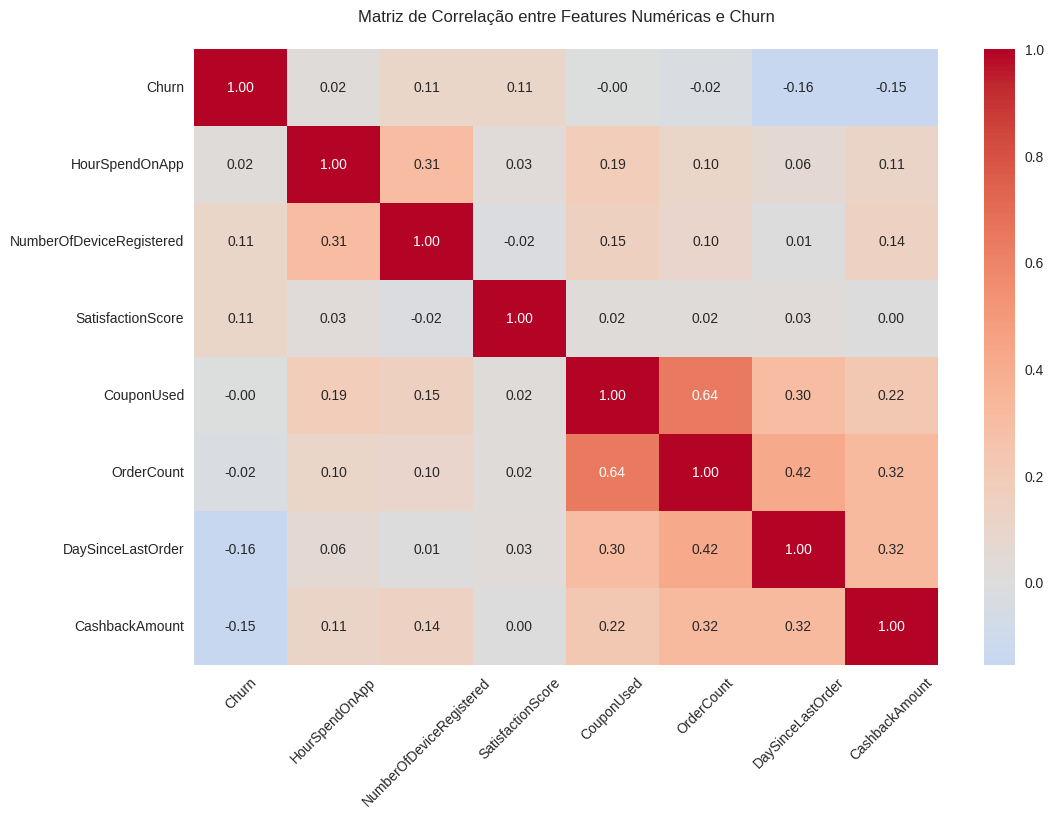

In [44]:
# Selecionar apenas colunas numéricas para análise de correlação
numeric_features = ['Churn', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
                   'SatisfactionScore', 'CouponUsed', 'OrderCount',
                    'DaySinceLastOrder', 'CashbackAmount']

# Matriz de correlação
corr_matrix = df[numeric_features].corr()

# Plotar heatmap de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação entre Features Numéricas e Churn', pad=20)
plt.xticks(rotation=45)
plt.show()

Insights:
1.Fatores com Maior Impacto no Churn:

- SatisfactionScore (0.11): Quanto maior a satisfação, maior a probabilidade de permanência (relação positiva)

- NumberOfDeviceRegistered (0.11): Clientes com mais dispositivos registrados tendem a permanecer mais

- DaySinceLastOrder (-0.16): Quanto mais dias desde o último pedido, maior o risco de churn (forte relação negativa)

- CashbackAmount (-0.15): Valores menores de cashback associados a maior churn

2. Relações Surpreendentes:

- HourSpendOnApp (0.02): Tempo no app tem correlação quase neutra com churn

- CouponUsed (-0.00): Uso de cupons não mostra impacto linear direto

In [49]:
#Tratando valores categóricos
df = pd.get_dummies(df, dtype = int)

In [51]:
#Definição das variáveis explicativas e target
X = df.drop(['CustomerID','Churn'], axis=1)
y = df['Churn']

#Normalizando variáveis explicativas
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Modelagem dos Dados - Regressão Logística, Random Forest e XGBoost

In [52]:
#Divisão de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [63]:
#Definição dos modelos a serem analisados
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

## Avaliação Inicial dos Modelos

In [64]:
base_results = []

for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }
    base_results.append(metrics)

base_metrics_df = pd.DataFrame(base_results)
print("\nDesempenho dos Modelos Base:")
display(base_metrics_df)


Desempenho dos Modelos Base:


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC
0,Logistic Regression,0.844583,0.558350,0.727273,0.126316,0.215247,0.708395
1,Random Forest,0.900533,0.740919,0.848214,0.500000,0.629139,0.902398
2,XGBoost,0.889876,0.734509,0.766129,0.500000,0.605096,0.895119


## Otimização com GridSearch

In [65]:
#pipeline com SMOTE(tratamento de dados desbalanceados) e modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', None)
])

### Hiperparâmetros para cada modelo
param_grids = {
    'Logistic Regression': {
        'model': [LogisticRegression(max_iter=1000, random_state=42)],
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    },
    'Random Forest': {
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__class_weight': ['balanced', None]
    },
    'XGBoost': {
        'model': [XGBClassifier(random_state=42, eval_metric='logloss')],
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6, 9],
        'model__learning_rate': [0.01, 0.1],
        'model__scale_pos_weight': [1, (len(y_train)-sum(y_train))/sum(y_train)]
    }
}

In [66]:
#Executando GridSearch
optimized_results = []
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name in base_models.keys():
    print(f"\nOtimizando {name}...")
    grid = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    # Armazenar o melhor modelo
    best_models[name] = grid.best_estimator_

    # Avaliar no conjunto de teste
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:,1]

    metrics = {
        'Model': f"{name} (Optimized)",
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Best Params': str(grid.best_params_)
    }
    optimized_results.append(metrics)


Otimizando Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Otimizando Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Otimizando XGBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


## Aplicando modelos otimizados

In [67]:
final_metrics_df = pd.DataFrame(base_results + optimized_results)

# Ordenar por F1-score
final_metrics_df = final_metrics_df.sort_values('F1', ascending=False).reset_index(drop=True)

print("\nResultados Finais Comparativos:")
display(final_metrics_df)


Resultados Finais Comparativos:


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1,ROC AUC,Best Params
0,XGBoost (Optimized),0.881883,0.826181,0.626667,0.742105,0.679518,0.911679,"{'model': XGBClassifier(base_score=None, boost..."
1,Random Forest,0.900533,0.740919,0.848214,0.500000,0.629139,0.902398,NaN
2,Random Forest (Optimized),0.889876,0.740801,0.753846,0.515789,0.612500,0.886836,{'model': RandomForestClassifier(random_state=...
3,XGBoost,0.889876,0.734509,0.766129,0.500000,0.605096,0.895119,NaN
4,Logistic Regression (Optimized),0.658082,0.649618,0.276888,0.636842,0.385965,0.706506,"{'model': LogisticRegression(max_iter=1000, ra..."
5,Logistic Regression,0.844583,0.558350,0.727273,0.126316,0.215247,0.708395,NaN


## Análise gráfica

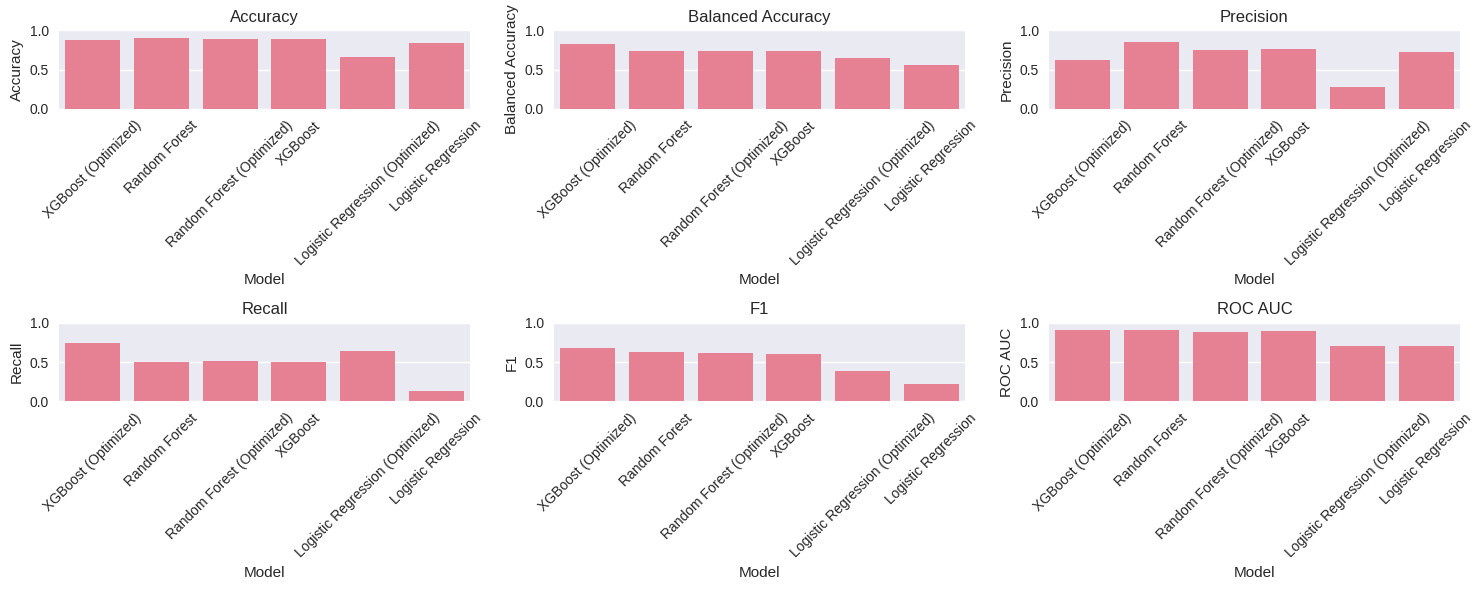

In [68]:
plt.figure(figsize=(15, 6))
metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x='Model', y=metric, data=final_metrics_df)
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## Matriz confusão do melhor modelo


Melhor modelo: XGBoost (Optimized)
Parâmetros: {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...), 'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__n_estimators': 200, 'model__scale_pos_weight': 4.941952506596306}


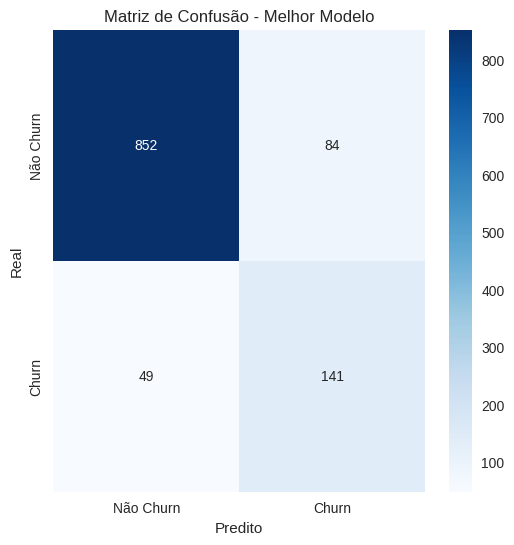

In [70]:
# Matriz de Confusão
best_model_name = final_metrics_df.iloc[0]['Model']
best_model = best_models[best_model_name.replace(' (Optimized)', '')]

print(f"\nMelhor modelo: {best_model_name}")
print(f"Parâmetros: {final_metrics_df.iloc[0]['Best Params']}")

y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Melhor Modelo')
plt.show()

## Insights Finais

- Acurácia Balanceada (82.6%): Melhor capacidade de prever ambas as classes (churn e não-churn)

- Recall (74.2%): Detecta 74% dos casos reais de churn (melhor entre todos)

- ROC AUC (91.2%): Excelente capacidade discriminatória

- Trade-off: Precisão mais baixa (62.7%) indica que quando prevê churn, acerta 63% das vezes

Insights Específicos por Modelo:
1. XGBoost vs Random Forest
Vantagem do XGBoost:

- +8.5% no Recall em relação ao RF otimizado (74.2% vs 51.6%)

- +6.7% no F1-Score (melhor balanceamento entre precisão e recall)

Ponto de atenção:

- Random Forest base teve precisão maior (84.8%), mas com recall muito baixo (50%)

2. Evolução com Otimização
- Ganho com otimização (XGBoost)
ganho_recall = 74.2 - 50.0  ( +24.2% )
ganho_f1 = 67.9 - 60.5      ( +7.4% )

- Perda com otimização (Random Forest)
perda_precisao = 75.4 - 84.8  ( -9.4% )

3. Regressão Logística
Problemas graves:

- Recall alto (63.7%) mas precisão muito baixa (27.7%) → Muitos falsos positivos

- Acurácia balanceada (65%) próxima ao aleatório (50%)